In [1]:
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from IPython.display import HTML
import great_tables as gt
from Animation import plot_animation

In [2]:
# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [ ]:
"""
Frequency of events that happen before/after throw
"""
game_events = game_events_subset.to_table().to_pandas()
game_events = game_events.sort_values(by=["game_str","play_per_game","timestamp"])

game_events['event_code_after_throw'] = game_events.groupby(
    ["game_str","play_per_game"])['event_code'].shift(-1) # -1 is after, +1 is before

game_events = game_events[game_events['event_code']==3]

df = game_events.groupby('preceding_event_code').agg(
    ct = ('preceding_event_code','size')
)
# df.head(10)

,ct
preceding_event_code,
2.0,8456
5.0,12
7.0,1
9.0,111
10.0,7
16.0,1742


MovieWriter imagemagick unavailable; using Pillow instead.


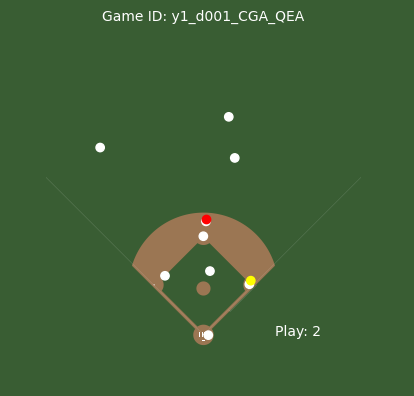

In [5]:
"""
Quick Visualization
"""
game_str = "y1_d001_CGA_QEA"
play_id = 2

player_position_df = player_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()
ball_position_df = ball_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()
plot_animation(player_position_df, ball_position_df, play_id, save_gif=True)

In [9]:
# Ball acquisition & Ball throw timestamps
acq_thr = game_events_subset.to_table(
    columns = ['game_str','play_id','timestamp','event_code']).to_pandas()
acq = acq_thr[acq_thr['event_code']==2]
acq = acq.rename(columns={"timestamp":"acq_time"}).drop(columns='event_code')
thr = acq_thr[acq_thr['event_code']==3]
thr = thr.rename(columns={"timestamp":"thr_time"}).drop(columns='event_code')
# Timestamp for when thrown ball becomes caught/bounced/etc. (next event_code)
end = acq_thr[acq_thr['event_code'].shift(1)==3]
end = end.rename(columns={"timestamp":"end_time"}).drop(columns='event_code')

# Ball position timestamps
ball = ball_position_subset.to_table().to_pandas()
ball = pd.merge(ball, acq, how="left", on=['game_str','play_id'])
ball = pd.merge(ball, thr, how="left", on=['game_str','play_id'])
ball = pd.merge(ball, end, how="left", on=['game_str','play_id'])

# Filter by timestamps between acq & end
ball = ball[ball['timestamp'] >= ball['acq_time']]
ball = ball[ball['timestamp'] <= ball['end_time']]

# Counts
print("Number of throws: ", len(acq_thr[acq_thr['event_code']==3].groupby(['game_str','play_id','event_code'])))
print("\n")
print("Mean ms between acquisition & throw: ", int((ball['thr_time']-ball['acq_time']).mean()))
print("Mean ms between throw & end: ", int((ball['end_time']-ball['thr_time']).mean()))
print("\n")
print("Expected # timestamps between acquisition & throw (50ms interval): ", int((ball['thr_time']-ball['acq_time']).mean()/50*9421))
print("Expected # timestamps between throw & end (50ms interval): ", int((ball['end_time']-ball['thr_time']).mean()/50*9421))
print("\n")
print("Actual # timestamps between acquisition & throw: ", len(ball[(ball['timestamp'] > ball['acq_time']) & (ball['timestamp'] < ball['thr_time'])]))
print("Actual # timestamps between throw & end: ", len(ball[(ball['timestamp'] > ball['thr_time']) & (ball['timestamp'] < ball['end_time'])]))

Number of throws:  9421


Mean ms between acquisition & throw:  1675
Mean ms between throw & end:  1771


Expected # timestamps between acquisition & throw (50ms interval):  315660
Expected # timestamps between throw & end (50ms interval):  333796


Actual # timestamps between acquisition & throw:  61393
Actual # timestamps between throw & end:  367805
